In [ ]:
!pip install -q torchsummary

In [ ]:
import torch
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary

In [ ]:
import albumentations as A

has the architecture to C1C2C3C40 (No MaxPooling, but 3 convolutions, where the last one has a stride of 2 instead) (If you can figure out how to use Dilated kernels here instead of MP or strided convolution, then 200pts extra!)
total RF must be more than 44
one of the layers must use Depthwise Separable Convolution
one of the layers must use Dilated Convolution
use GAP (compulsory):- add FC after GAP to target #of classes (optional)

In [ ]:
class DepthwiseSeparableConv2d(nn.Module):
 def __init__(self, nin, nout):
   super(DepthwiseSeparableConv2d, self).__init__()
   self.depthwise = nn.Conv2d(nin, nin, kernel_size=3, padding=1, groups=nin)
   self.pointwise = nn.Conv2d(nin, nout, kernel_size=1)

 def forward(self, x):
   out = self.depthwise(x)
   out = self.pointwise(out)
   return out

In [ ]:


class Net(nn.Module):
    def __init__(self, dropout_value=0.1):
        super(Net, self).__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, dilation=2,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        ) # output_size = 32/3

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            DepthwiseSeparableConv2d(16,32),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, stride=2,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
        )
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, stride=2,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
        )
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 1), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        ) # output_size = 16/10/2
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.gap(x)
        x = self.convblock5(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 32, 32, 32]           4,608
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 64, 28, 28]          18,432
              ReLU-8           [-1, 64, 28, 28]               0
       BatchNorm2d-9           [-1, 64, 28, 28]             128
           Conv2d-10           [-1, 16, 30, 30]           1,024
             ReLU-11           [-1, 16, 30, 30]               0
      BatchNorm2d-12           [-1, 16, 30, 30]              32
          Dropout-13           [-1, 16, 30, 30]               0
           Conv2d-14           [-1

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(15),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])

In [ ]:
from albumentations.pytorch import ToTensorV2

In [ ]:
# Train Phase transformations
train_transforms = A.Compose([
                              A.HorizontalFlip(),
                              A.ShiftScaleRotate(),
                              A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, fill_value=[0.491, 0.4821 ,0.4465], mask_fill_value = None),
                              # A.Normalize(mean=(0.491, 0.482 ,0.446), std=(0.2470, 0.243 0.261)),
                              A.Normalize(mean=(0.491, 0.482, 0.446), std=(0.247, 0.243, 0.261)),
                              ToTensorV2(),
                              ])

# Test Phase transformations
test_transforms = A.Compose([
                              A.Normalize(mean=(0.491, 0.482, 0.446), std=(0.202, 0.1994, 0.201)),
                              ToTensorV2(),
                            ])

In [60]:
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True)
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True)

Files already downloaded and verified
Files already downloaded and verified


In [61]:
class AlbumentationsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.dataset[index]
        image = np.array(image)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

    def __len__(self):
        return len(self.dataset)

In [62]:
train = AlbumentationsDataset(train, transform=train_transforms)
test = AlbumentationsDataset(test, transform=test_transforms)


In [63]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


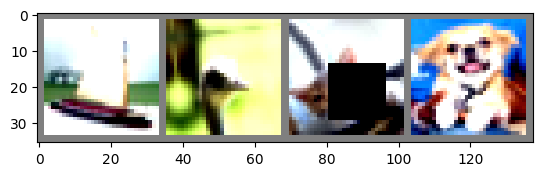

ship  bird  cat   dog  


In [64]:
#functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [65]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    misclassified_images = []
    misclassified_targets = []
    misclassified_predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            misclassified_mask = pred.eq(target.view_as(pred)) == 0
            misclassified_images.append(data[misclassified_mask.view(-1)])  # Flatten the mask
            misclassified_targets.append(target[misclassified_mask.view(-1)])
            misclassified_predictions.append(pred[misclassified_mask.view(-1)])

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return misclassified_images, misclassified_targets, misclassified_predictions

In [66]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    misclassified_images, misclassified_targets, misclassified_predictions = test(model, device, test_loader)

EPOCH: 0


Loss=1.891667366027832 Batch_id=97 Accuracy=23.61: 100%|██████████| 98/98 [00:15<00:00,  6.44it/s]



Test set: Average loss: 1.8026, Accuracy: 3182/10000 (31.82%)

EPOCH: 1


Loss=1.7428158521652222 Batch_id=97 Accuracy=34.91: 100%|██████████| 98/98 [00:13<00:00,  7.28it/s]



Test set: Average loss: 1.5801, Accuracy: 4137/10000 (41.37%)

EPOCH: 2


Loss=1.5806561708450317 Batch_id=97 Accuracy=40.40: 100%|██████████| 98/98 [00:13<00:00,  7.07it/s]



Test set: Average loss: 1.7442, Accuracy: 4123/10000 (41.23%)

EPOCH: 3


Loss=1.5103776454925537 Batch_id=97 Accuracy=43.67: 100%|██████████| 98/98 [00:13<00:00,  7.23it/s]



Test set: Average loss: 1.4569, Accuracy: 4777/10000 (47.77%)

EPOCH: 4


Loss=1.4228506088256836 Batch_id=97 Accuracy=45.70: 100%|██████████| 98/98 [00:13<00:00,  7.06it/s]



Test set: Average loss: 1.3490, Accuracy: 5072/10000 (50.72%)

EPOCH: 5


Loss=1.458436369895935 Batch_id=97 Accuracy=47.96: 100%|██████████| 98/98 [00:13<00:00,  7.29it/s]



Test set: Average loss: 1.3671, Accuracy: 5151/10000 (51.51%)

EPOCH: 6


Loss=1.4318184852600098 Batch_id=97 Accuracy=49.42: 100%|██████████| 98/98 [00:15<00:00,  6.40it/s]



Test set: Average loss: 1.3515, Accuracy: 5097/10000 (50.97%)

EPOCH: 7


Loss=1.325595498085022 Batch_id=97 Accuracy=51.23: 100%|██████████| 98/98 [00:14<00:00,  6.92it/s]



Test set: Average loss: 1.2301, Accuracy: 5568/10000 (55.68%)

EPOCH: 8


Loss=1.3572280406951904 Batch_id=97 Accuracy=52.26: 100%|██████████| 98/98 [00:13<00:00,  7.08it/s]



Test set: Average loss: 1.2251, Accuracy: 5659/10000 (56.59%)

EPOCH: 9


Loss=1.2740236520767212 Batch_id=97 Accuracy=53.98: 100%|██████████| 98/98 [00:13<00:00,  7.07it/s]



Test set: Average loss: 1.1607, Accuracy: 5857/10000 (58.57%)

EPOCH: 10


Loss=1.3199645280838013 Batch_id=97 Accuracy=54.54: 100%|██████████| 98/98 [00:13<00:00,  7.04it/s]



Test set: Average loss: 1.1578, Accuracy: 5879/10000 (58.79%)

EPOCH: 11


Loss=1.1479190587997437 Batch_id=97 Accuracy=55.54: 100%|██████████| 98/98 [00:14<00:00,  6.55it/s]



Test set: Average loss: 1.1935, Accuracy: 5767/10000 (57.67%)

EPOCH: 12


Loss=1.2904008626937866 Batch_id=97 Accuracy=56.19: 100%|██████████| 98/98 [00:13<00:00,  7.20it/s]



Test set: Average loss: 1.0680, Accuracy: 6159/10000 (61.59%)

EPOCH: 13


Loss=1.149875521659851 Batch_id=97 Accuracy=56.84: 100%|██████████| 98/98 [00:13<00:00,  7.01it/s]



Test set: Average loss: 1.0406, Accuracy: 6315/10000 (63.15%)

EPOCH: 14


Loss=1.1755043268203735 Batch_id=97 Accuracy=57.81: 100%|██████████| 98/98 [00:13<00:00,  7.16it/s]



Test set: Average loss: 1.0455, Accuracy: 6328/10000 (63.28%)

EPOCH: 15


Loss=1.1027063131332397 Batch_id=97 Accuracy=58.38: 100%|██████████| 98/98 [00:13<00:00,  7.06it/s]



Test set: Average loss: 1.0020, Accuracy: 6437/10000 (64.37%)

EPOCH: 16


Loss=1.1021850109100342 Batch_id=97 Accuracy=59.06: 100%|██████████| 98/98 [00:13<00:00,  7.11it/s]



Test set: Average loss: 1.0049, Accuracy: 6433/10000 (64.33%)

EPOCH: 17


Loss=1.0904499292373657 Batch_id=97 Accuracy=59.32: 100%|██████████| 98/98 [00:13<00:00,  7.03it/s]



Test set: Average loss: 1.0045, Accuracy: 6492/10000 (64.92%)

EPOCH: 18


Loss=1.0793070793151855 Batch_id=97 Accuracy=60.00: 100%|██████████| 98/98 [00:13<00:00,  7.20it/s]



Test set: Average loss: 0.9582, Accuracy: 6614/10000 (66.14%)

EPOCH: 19


Loss=1.176132321357727 Batch_id=97 Accuracy=60.44: 100%|██████████| 98/98 [00:13<00:00,  7.13it/s]



Test set: Average loss: 0.9291, Accuracy: 6684/10000 (66.84%)

EPOCH: 20


Loss=0.9880543947219849 Batch_id=97 Accuracy=61.14: 100%|██████████| 98/98 [00:13<00:00,  7.19it/s]



Test set: Average loss: 0.9739, Accuracy: 6610/10000 (66.10%)

EPOCH: 21


Loss=1.086795687675476 Batch_id=97 Accuracy=61.00: 100%|██████████| 98/98 [00:14<00:00,  6.63it/s]



Test set: Average loss: 0.9383, Accuracy: 6730/10000 (67.30%)

EPOCH: 22


Loss=1.0849188566207886 Batch_id=97 Accuracy=61.49: 100%|██████████| 98/98 [00:13<00:00,  7.07it/s]



Test set: Average loss: 0.9088, Accuracy: 6804/10000 (68.04%)

EPOCH: 23


Loss=1.1292624473571777 Batch_id=97 Accuracy=62.16: 100%|██████████| 98/98 [00:13<00:00,  7.18it/s]



Test set: Average loss: 0.9267, Accuracy: 6777/10000 (67.77%)

EPOCH: 24


Loss=1.0020711421966553 Batch_id=97 Accuracy=62.50: 100%|██████████| 98/98 [00:13<00:00,  7.18it/s]



Test set: Average loss: 0.9426, Accuracy: 6746/10000 (67.46%)

EPOCH: 25


Loss=1.0367228984832764 Batch_id=97 Accuracy=62.78: 100%|██████████| 98/98 [00:13<00:00,  7.10it/s]



Test set: Average loss: 0.8511, Accuracy: 7048/10000 (70.48%)

EPOCH: 26


Loss=0.9840490221977234 Batch_id=97 Accuracy=63.46: 100%|██████████| 98/98 [00:14<00:00,  6.89it/s]



Test set: Average loss: 0.8595, Accuracy: 6929/10000 (69.29%)

EPOCH: 27


Loss=1.0226930379867554 Batch_id=97 Accuracy=63.66: 100%|██████████| 98/98 [00:13<00:00,  7.07it/s]



Test set: Average loss: 0.8502, Accuracy: 7024/10000 (70.24%)

EPOCH: 28


Loss=0.989355742931366 Batch_id=97 Accuracy=63.72: 100%|██████████| 98/98 [00:13<00:00,  7.08it/s]



Test set: Average loss: 0.8401, Accuracy: 7022/10000 (70.22%)

EPOCH: 29


Loss=0.9876107573509216 Batch_id=97 Accuracy=64.11: 100%|██████████| 98/98 [00:13<00:00,  7.08it/s]



Test set: Average loss: 0.8465, Accuracy: 7096/10000 (70.96%)

EPOCH: 30


Loss=0.9455113410949707 Batch_id=97 Accuracy=64.05: 100%|██████████| 98/98 [00:13<00:00,  7.04it/s]



Test set: Average loss: 0.8206, Accuracy: 7112/10000 (71.12%)

EPOCH: 31


Loss=1.1051397323608398 Batch_id=97 Accuracy=64.67: 100%|██████████| 98/98 [00:13<00:00,  7.07it/s]



Test set: Average loss: 0.8792, Accuracy: 6967/10000 (69.67%)

EPOCH: 32


Loss=0.9935450553894043 Batch_id=97 Accuracy=64.76: 100%|██████████| 98/98 [00:15<00:00,  6.46it/s]



Test set: Average loss: 0.7975, Accuracy: 7220/10000 (72.20%)

EPOCH: 33


Loss=1.0555875301361084 Batch_id=97 Accuracy=65.53: 100%|██████████| 98/98 [00:13<00:00,  7.04it/s]



Test set: Average loss: 0.7999, Accuracy: 7279/10000 (72.79%)

EPOCH: 34


Loss=0.9507930278778076 Batch_id=97 Accuracy=65.39: 100%|██████████| 98/98 [00:13<00:00,  7.06it/s]



Test set: Average loss: 0.7914, Accuracy: 7283/10000 (72.83%)

EPOCH: 35


Loss=0.8544866442680359 Batch_id=97 Accuracy=65.38: 100%|██████████| 98/98 [00:14<00:00,  6.85it/s]



Test set: Average loss: 0.7997, Accuracy: 7185/10000 (71.85%)

EPOCH: 36


Loss=0.910394012928009 Batch_id=97 Accuracy=66.02: 100%|██████████| 98/98 [00:14<00:00,  6.95it/s]



Test set: Average loss: 0.8133, Accuracy: 7166/10000 (71.66%)

EPOCH: 37


Loss=1.0701262950897217 Batch_id=97 Accuracy=66.28: 100%|██████████| 98/98 [00:13<00:00,  7.09it/s]



Test set: Average loss: 0.7636, Accuracy: 7351/10000 (73.51%)

EPOCH: 38


Loss=0.9333615899085999 Batch_id=97 Accuracy=66.37: 100%|██████████| 98/98 [00:13<00:00,  7.08it/s]



Test set: Average loss: 0.8263, Accuracy: 7109/10000 (71.09%)

EPOCH: 39


Loss=1.0465013980865479 Batch_id=97 Accuracy=66.55: 100%|██████████| 98/98 [00:13<00:00,  7.15it/s]



Test set: Average loss: 0.7458, Accuracy: 7378/10000 (73.78%)



Text(0.5, 1.0, 'Test Accuracy')

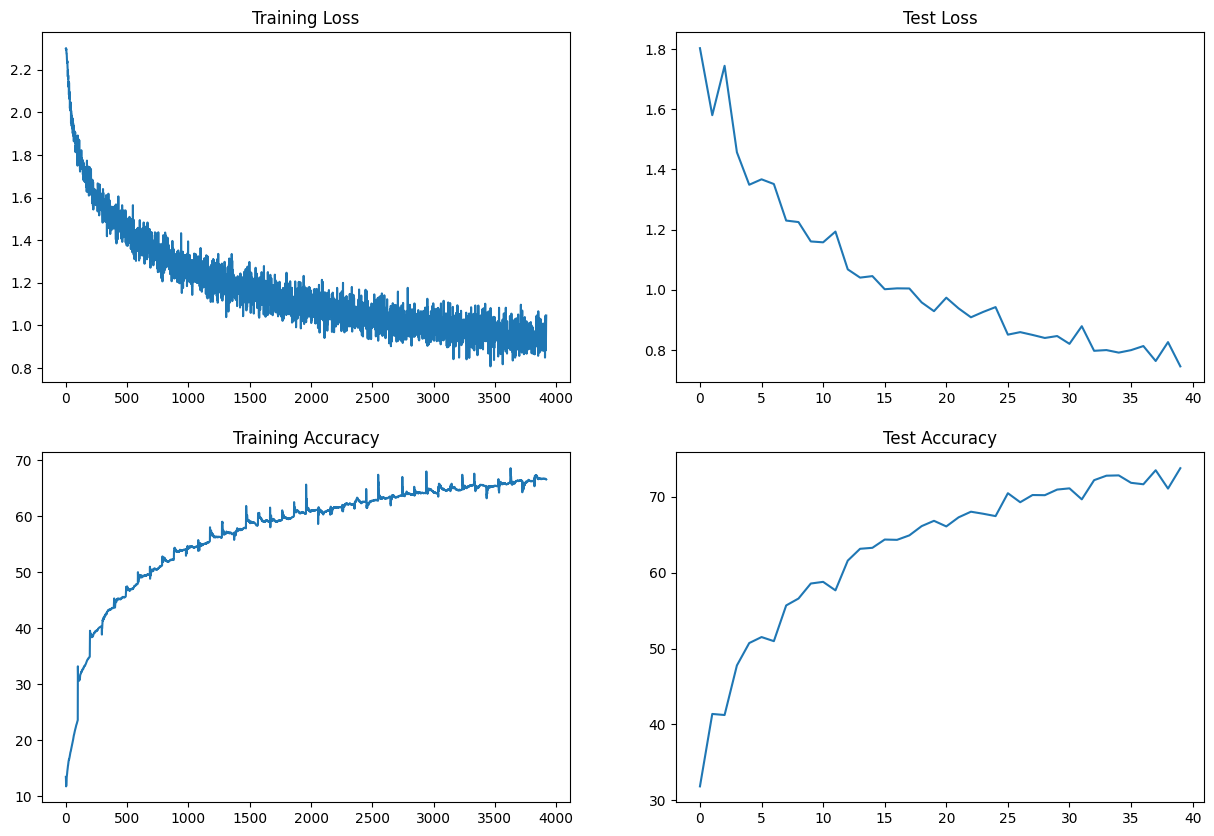

In [67]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

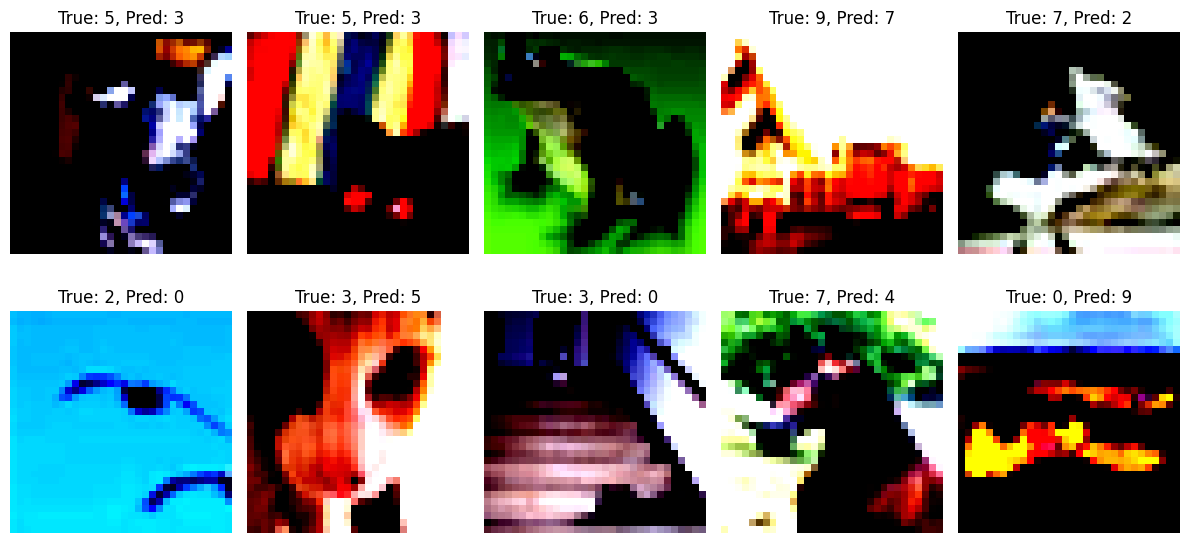

In [68]:

# Sample 10 misclassified images
num_samples = 10
sample_indices = np.random.choice(len(misclassified_images), min(num_samples, len(misclassified_images)), replace=False)

# Plot misclassified images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < len(sample_indices):
        ax.imshow(misclassified_images[sample_indices[i]][0].cpu().numpy().transpose((1, 2, 0)))
        ax.set_title(f"True: {misclassified_targets[sample_indices[i]][0].item()}, Pred: {misclassified_predictions[sample_indices[i]][0].item()}")
    ax.axis('off')
plt.tight_layout()
plt.show()

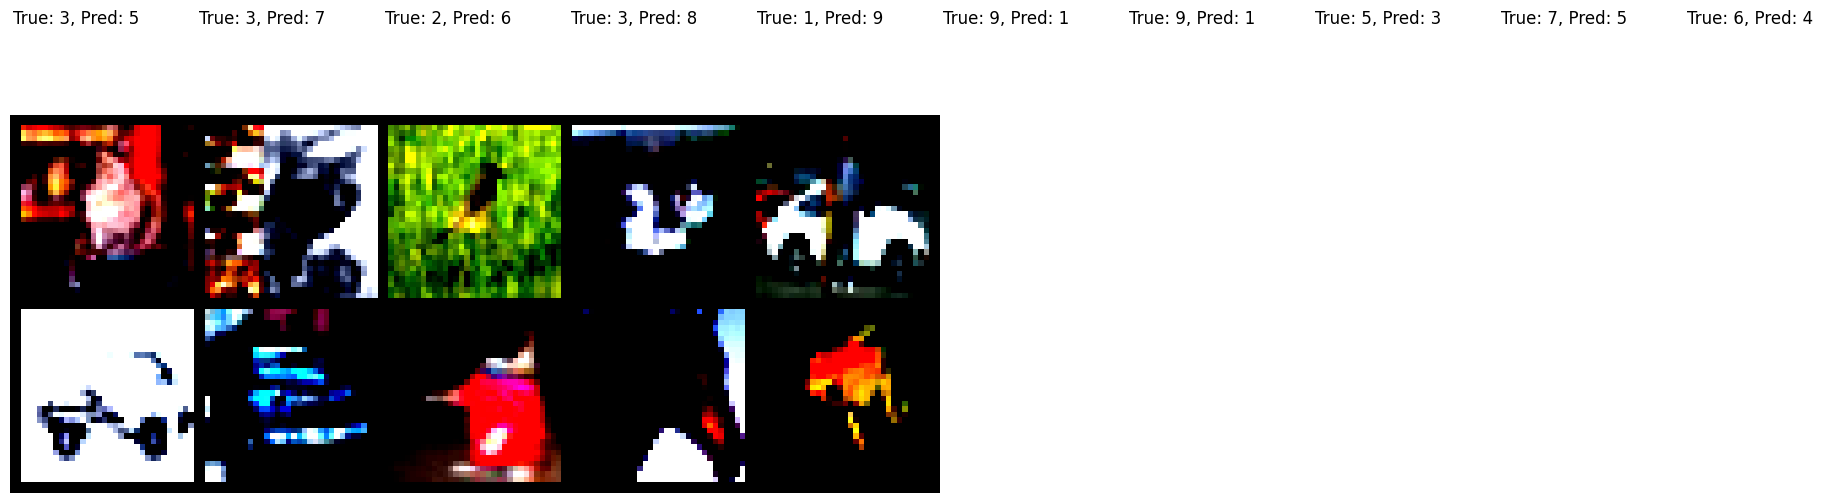

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Sample 10 misclassified images
num_samples = 10
sample_indices = torch.randperm(len(misclassified_images))[:min(num_samples, len(misclassified_images))]

# Prepare images and labels for plotting
images = [misclassified_images[idx][0].cpu() for idx in sample_indices]
labels_true = [misclassified_targets[idx][0].item() for idx in sample_indices]
labels_pred = [misclassified_predictions[idx][0].item() for idx in sample_indices]

# Plot misclassified images using torch grid
img_grid = make_grid(images, nrow=5)
plt.figure(figsize=(12, 6))
plt.imshow(img_grid.permute(1, 2, 0).cpu().numpy())  # Move tensor to CPU and convert to numpy array
plt.axis('off')

# Add titles to each sub-image
for i in range(num_samples):
    plt.text(i * img_grid.shape[2] / 5, -20, f'True: {labels_true[i]}, Pred: {labels_pred[i]}', fontsize=12, ha='left', color='black', va='top', rotation=0)

plt.show()
